# Data Cleaning and Exploration of the NYC High School Data


This projects aims at finding useful correlations between the SAT scores and other factors by 
cleaning the dataset, combining multiple datasets together and exploring the correlations using 
visualizations.

The data for the project can be found [here](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)

## Reading in the data:

The first step is to read in all the datasets that we have at our disposal. 

In order to analyze the SAT scores we are going to take a look at data related to:

- **SAT scores by school** - SAT scores for each high school in New York City
- **School attendance** - Attendance information for each school in New York City
- **Class size** - Information on class size for each school
- **AP test results** - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- **Graduation outcomes** - The percentage of students who graduated, and other outcome information
- **Demographics** - Demographic information for each school
- **School survey** - Surveys of parents, teachers, and students at each school

The first step to try and merge all the datasets we have into a single dataframe and see if we can find 
interesting correlations and patterns between the SAT scores and the other factors listed above

## Reading in the CSV files

In [1]:
import pandas as pd
import numpy
import re


# Creating a list to store all our CSV files 

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "sat_results.csv",
    "hs_directory.csv"
]

# The dictionary data is where we are going to store the name of the data frame as a key and the 
# value is going to be the dataframe itself

data = {}

for f in data_files:
    d = pd.read_csv(f)
    data[f.replace(".csv", "")] = d

## Reading in the text files

We have two text files that want to read in seperatly:

- They have different encoding and delimters compared to the CSV files.
- Looking at the data dictionary we want to rename the "dbn" column to "DBN" so that it is 
  consistent with the other datasets as we are going to use this column as the unique identifier to merge
  all other datasets.
- Picking out columns that are appropriate for the analysis

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]
 
data["survey"] = survey

## Cleaning up the datasets before merging them

Let's take a look at the first 5 rows of all our dataframes:

In [3]:
for key, value in data.items():
    print(value.head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

Let's also take a look at the column types for all the dataframes:

In [4]:
for key, value in data.items():
    print(value.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
DBN                                     258 non-null object
SchoolName                              258 non-null object
AP Test Takers                          258 non-null object
Total Exams Taken                       258 non-null object
Number of Exams with scores 3 4 or 5    258 non-null object
dtypes: object(5)
memory usage: 10.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 16 columns):
CSD                                     27611 non-null int64
BOROUGH                                 27611 non-null object
SCHOOL CODE                             27611 non-null object
SCHOOL NAME                             27611 non-null object
GRADE                                   26127 non-null object
PROGRAM TYPE                            26127 non-null object
CORE SUBJECT (MS CORE and 9-12 ONLY)    26127 non-null object
CORE COU

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2774 entries, N_p to DBN
dtypes: float64(2762), int64(6), object(6)
memory usage: 36.0+ MB
None


## Converting columns to numeric

Certain columns that are non-numeric are going to be converted to numeric using the code shown below:

In [5]:
#Converting the sat scores to numeric: 

cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
    
# Merging the Math, Crit. Reading and Writing Avg scores into a single column:

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

When we explored the data we found out that the latitude and longitiude information were stored in
the 'Location 1' columns as:

In [6]:
data['hs_directory'].head(1)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."


In order to extract the latitude and longitude we use the code shown below:

In [7]:
#Creating functions to extract the latitude 

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

#Creating new columns to store latitude and longitudes 

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

#Converting the latitude and longitude to numeric

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [8]:
data['hs_directory']['lat'].head(1)

0    40.670299
Name: lat, dtype: float64

In [9]:
data['hs_directory']['lon'].head(1)

0   -73.961648
Name: lon, dtype: float64

Converting the columns in the "ap_2010" dataframe to numeric:

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

   Let's now take a look at the "hs_directory" dataframe:

In [11]:
data["hs_directory"].head(1)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648


We need to reaname the "dbn" column here to "DBN" so that it stays consistent with other dataframes:

In [12]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

Let's now take a look at the "class_size" dataframe:

In [13]:
data["class_size"].head(1)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN


We can see that: 

- It does not have unique "DBN" columns 
- The DBN column can be created if we merge the "CSD" and "SCHOOL CODE" columns 
- If we pad a 0 if the number in the "CSD" column is a single digit. 

In order to do the above we use the code shown below: 

In [14]:
#Creating a function that will pad a 0 if the number is a single digit 

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

#Applying the function and creating a new column called "padded_csd"    
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

#Adding the padded_csd column to the SCHOOL CODE column

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Condensing the dataframes

Since we are going to merge the dataframes on the 'DBN' column which we is a unique indentifer for 
each school, it has to be unique for every other dataframe in our dataset. 

The "DBN" column while unique in the "sat_results" dataframe is not unique in the other dataframes and 
we would like to aggregate or condense these dataframes in such a way that the "DBN" column has unique values

In [15]:
# Condensing the "class_size" dataframe 

class_size = data["class_size"]

#Filtering the dataframe to include only grades 9-12 since we are interested only in high school stats

class_size = class_size[class_size["GRADE "] == "09-12"]

# Filtering the program type to General education 

class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#Grouping by the "DBN" column and extracting the mean for each "DBN" group across every numeric column

class_size = class_size.groupby("DBN").agg(numpy.mean)

#Reseting the index so that "DBN" goes from being an index column to an actual column 

class_size.reset_index(inplace=True)
data["class_size"] = class_size

In [16]:
#Condensing the "demographics" dataframe in order to have unique DBN values 

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

In [17]:
#Condensing the "graduation" dataframe in order to have unique DBN values

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Combing the datasets

There are a plethora of strategies to combine datasets together and the it depends on many factors:

- The "ap_2010" and the "graduation" dataframes have a lot of missing values in the "DBN" 
  column and hence we are going to combine them using a "left" join using the "sat_results"
  as the dataframe on the left. 

In [18]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

- The "class_size", "demographics", "survey" and "hs_directory" dataframes have fewer missing values 
  and hence we can merge them together using an inner join

In [19]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#Filling the numeric columns having missing values with a mean imputation

combined = combined.fillna(combined.mean())

#Filling the object or string columns with a 0 for the missing values

combined = combined.fillna(0)

## Adding a school district column 

Using the code below we can extract the first two characters of the "DBN" column which can 
act as the school district column so that we can find some interesting patterns in the data
by district.

In [20]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Finding correlations

We now want to understand which columns correlate the most with the sat_scores:

In [21]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

Since we bunched up all the "survey_fields" of interest together earlier let's visualize the correlations 
between the survey fields and the sat scores:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


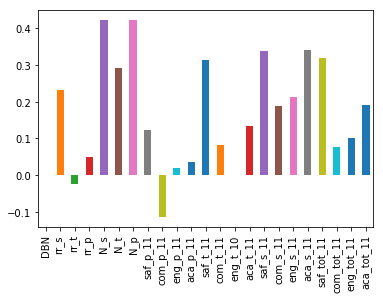

In [24]:
%matplotlib inline

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

combined.corr()["sat_score"][survey_fields].plot.bar()

- There are high correlations between N_s (Number of students), N_t (Number of teachers), N_p (Number of parents)   and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.


- It is more interesting that rr_s, the student response rate, or the percentage of students that completed the     survey, correlates with sat_score. This might make sense because students who are more likely to fill out         surveys may be more likely to also be doing well academically.


- How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as   it's hard to teach or learn in an unsafe environment.


- The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards,   correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or         aca_p_11, how parents perceive academic standards.

## Exploring student safety

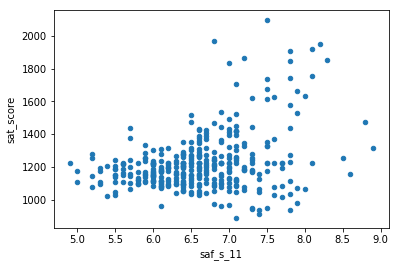

In [25]:
combined.plot.scatter("saf_s_11", "sat_score")

From the plot above we can observe that:

- There appears to be a correlation between SAT scores and safety, although it isn't that strong. 

- It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few       schools with low safety scores and low SAT scores. 

- No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

## Racial differences in SAT scores



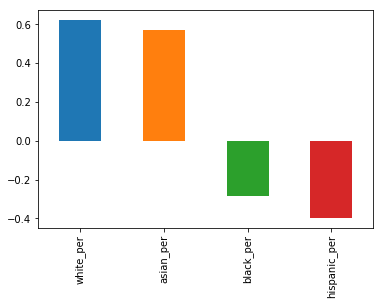

In [28]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

From the plot above we can see that:

- It looks like a higher percentage of white or asian students at a school correlates positively with sat score,     whereas a higher percentage of black or hispanic students correlates negatively with sat score. 

- This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher         percentage of black or hispanic students.

Let's take a look at how the hispanic students performed on the SAT:

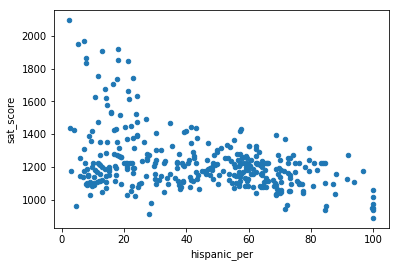

In [30]:
combined.plot.scatter("hispanic_per", "sat_score")

From the plot above we can see that schools with a higher percentage of hispanic students performed 
badly on the SAT.

Let's take a look at the school names where the percentage of hispanic students are greater than 95.

In [31]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


From the schools above we can see that:
    
- Most schools are schools for language or international schools.
- The schools listed above appear to primarily be geared towards recent immigrants to the US. 
- These schools have a lot of students who are learning English, which would explain the lower SAT scores.

Let's now take a look at the schools where the hispanic students are less than 10% and who get SAT scores higher than 1800:

In [32]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


From the schools listed above we can see that: 

- Many of the schools above appear to be specialized science and technology schools that receive extra funding,     and only admit students who pass an entrance exam. 
- This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -they are students from all over New York City who did well on a standardized test.

## SAT Scores by Gender

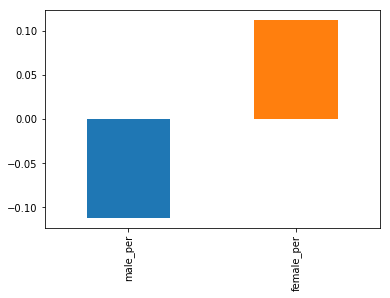

In [33]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

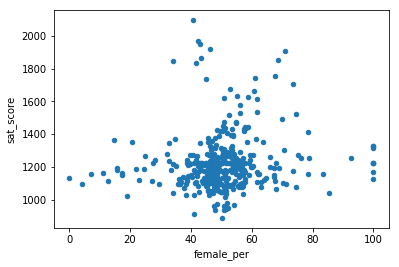

In [34]:
combined.plot.scatter("female_per", "sat_score")

From the plot above between the Sat Scores and the Percentage of females:
    
- There is no real correlation between SAT scores and the percentage of females in a school.
- However there is a small cluster of schools with high percentages of females (60 - 80) and high 
  SAT scores

## SAT Scores Vs. AP test takers

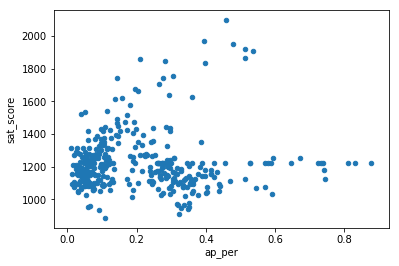

In [36]:
#Calculating the percentage of AP test takers

combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]


combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Conclusion 

In the project above we:

- Cleaned the NYC high school data
- Condensed the different datasets
- Merged all the data we had into a single dataframe for analysis
- Visualized the correlations in the data